<a href="https://colab.research.google.com/github/manasasuryasubrahmanayeswari/Fashion_Classification_Project/blob/master/Fashion_Classification_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# installing kaggle library
! pip install kaggle


In [3]:
# configuring the path of kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# Create a folder to store the dataset
!mkdir -p fashion_dataset

# Download and unzip Fashion Product Images (Small)
!kaggle datasets download -d paramaggarwal/fashion-product-images-small -p fashion_dataset --unzip


Dataset URL: https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small
License(s): MIT
100% 563M/565M [00:04<00:00, 165MB/s]
100% 565M/565M [00:04<00:00, 124MB/s]


In [3]:
import os

data_path = "fashion_dataset"
print(os.listdir(data_path))


['images', 'styles.csv', 'myntradataset']


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import os
from PIL import Image


In [5]:
# Load CSV
df = pd.read_csv("/content/fashion_dataset/styles.csv", engine='python', on_bad_lines='skip')

# Drop rows missing important columns
df = df.dropna(subset=['masterCategory', 'subCategory', 'articleType'])

# Check dataset info
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44424 entries, 0 to 44423
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  44424 non-null  int64  
 1   gender              44424 non-null  object 
 2   masterCategory      44424 non-null  object 
 3   subCategory         44424 non-null  object 
 4   articleType         44424 non-null  object 
 5   baseColour          44409 non-null  object 
 6   season              44403 non-null  object 
 7   year                44423 non-null  float64
 8   usage               44107 non-null  object 
 9   productDisplayName  44417 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 3.4+ MB


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [6]:


from sklearn.preprocessing import LabelEncoder

le_master = LabelEncoder()
df['masterCategory_encoded'] = le_master.fit_transform(df['masterCategory'])



In [13]:
import os

# Add a 'filename' column
df['filename'] = df['id'].astype(str) + ".jpg"

# Keep only rows where the image file exists
df = df[df['filename'].apply(lambda x: os.path.exists(f"/content/fashion_dataset/images/{x}"))]

print("Number of valid images:", len(df))


Number of valid images: 44419


In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_gen = datagen.flow_from_dataframe(
    dataframe=df,
    directory="/content/fashion_dataset/images",
    x_col="filename",
    y_col="masterCategory",
    subset="training",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(128,128),
)

val_gen = datagen.flow_from_dataframe(
    dataframe=df,
    directory="/content/fashion_dataset/images",
    x_col="filename",
    y_col="masterCategory",
    subset="validation",
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode="categorical",
    target_size=(128,128),
)


Found 35536 validated image filenames belonging to 7 classes.
Found 8883 validated image filenames belonging to 7 classes.


In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

num_classes = len(train_gen.class_indices)  # automatically 7

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,393,223 (28.20 MB)

 Trainable params: 7,393,223 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
history = model.fit(train_gen, validation_data=val_gen, epochs=10)


Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1111/1111 ━━━━━━━━━━━━━━━━━━━━ 921s 827ms/step - accuracy: 0.8685 - loss: 0.4467 - val_accuracy: 0.9571 - val_loss: 0.1408
Epoch 2/10
1111/1111 ━━━━━━━━━━━━━━━━━━━━ 902s 809ms/step - accuracy: 0.9597 - loss: 0.1414 - val_accuracy: 0.9642 - val_loss: 0.1234
Epoch 3/10
1111/1111 ━━━━━━━━━━━━━━━━━━━━ 898s 808ms/step - accuracy: 0.9702 - loss: 0.1090 - val_accuracy: 0.9729 - val_loss: 0.0971
Epoch 4/10
1111/1111 ━━━━━━━━━━━━━━━━━━━━ 904s 813ms/step - accuracy: 0.9776 - loss: 0.0820 - val_accuracy: 0.9731 - val_loss: 0.1094
Epoch 5/10
1111/1111 ━━━━━━━━━━━━━━━━━━━━ 897s 807ms/step - accuracy: 0.9807 - loss: 0.0759 - val_accuracy: 0.9651 - val_loss: 0.1326
Epoch 6/10
1111/1111 ━━━━━━━━━━━━━━━━━━━━ 892s 803ms/step - accuracy: 0.9743 - loss: 0.0877 - val_accuracy: 0.9752 - val_loss: 0.1027
Epoch 7/10
1111/1111 ━━━━━━━━━━━━━━━━━━━━ 892s 803ms/step - accuracy: 0.9849 - loss: 0.0532 - val_accuracy: 0.9768 - val_loss: 0.0966
Epoch 8/10
1111/1111 ━━━━━━━━━━━━━━━━━━━━ 926s 834ms/step - accuracy: 0.9

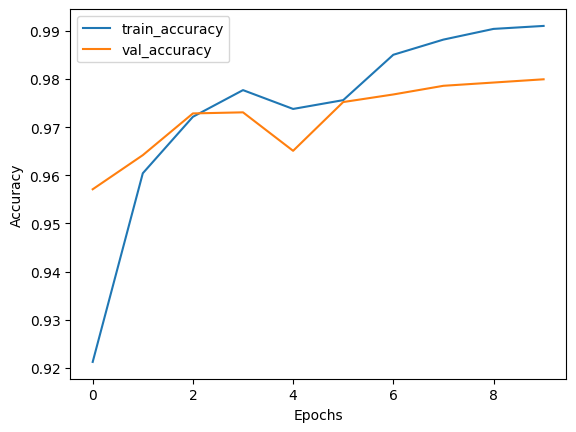

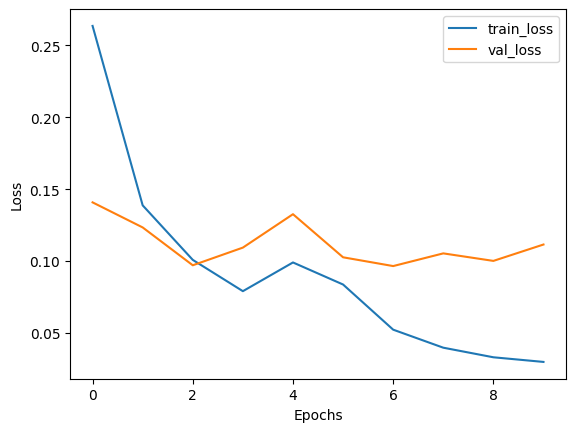

In [17]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [18]:
val_loss, val_acc = model.evaluate(val_gen)
print(f"Validation Accuracy: {val_acc:.2f}")
print(f"Validation Loss: {val_loss:.2f}")


278/278 ━━━━━━━━━━━━━━━━━━━━ 70s 251ms/step - accuracy: 0.9775 - loss: 0.1190
Validation Accuracy: 0.98
Validation Loss: 0.11


In [21]:
model.save("fashion_classifier.keras")


In [22]:
import numpy as np
from tensorflow.keras.preprocessing import image

# pick one test image
img_path = "/content/fashion_dataset/images/15970.jpg"
img = image.load_img(img_path, target_size=(128,128))
img_array = image.img_to_array(img)/255.0
img_array = np.expand_dims(img_array, axis=0)

pred = model.predict(img_array)
predicted_class = np.argmax(pred, axis=1)

print("Predicted class:", predicted_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
Predicted class: [1]


In [24]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# True labels from validation generator
y_true = val_gen.classes

# Predictions
y_pred = model.predict(val_gen, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Make sure target names match the actual classes present in y_true
from sklearn.utils.multiclass import unique_labels
labels = unique_labels(y_true, y_pred_classes)

# Map back to class names
class_names = [k for k,v in val_gen.class_indices.items() if v in labels]

print(classification_report(y_true, y_pred_classes, labels=labels, target_names=class_names))


278/278 ━━━━━━━━━━━━━━━━━━━━ 66s 238ms/step
                precision    recall  f1-score   support

   Accessories       0.97      0.97      0.97      2273
       Apparel       0.99      0.99      0.99      4247
      Footwear       0.99      0.99      0.99      1857
    Free Items       0.00      0.00      0.00        21
 Personal Care       0.94      0.98      0.96       483
Sporting Goods       0.00      0.00      0.00         2

      accuracy                           0.98      8883
     macro avg       0.65      0.65      0.65      8883
  weighted avg       0.98      0.98      0.98      8883



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [25]:
val_loss, val_acc = model.evaluate(val_gen, verbose=1)
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation Loss: {val_loss:.4f}")



278/278 ━━━━━━━━━━━━━━━━━━━━ 66s 238ms/step - accuracy: 0.9775 - loss: 0.1190
Validation Accuracy: 0.9800
Validation Loss: 0.1115


In [26]:
from sklearn.metrics import accuracy_score

val_accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Validation Accuracy (sklearn): {val_accuracy:.4f}")


Validation Accuracy (sklearn): 0.9800


In [27]:
train_acc = history.history['accuracy'][-1]
val_acc   = history.history['val_accuracy'][-1]

print(f"Final Training Accuracy: {train_acc:.4f}")
print(f"Final Validation Accuracy: {val_acc:.4f}")


Final Training Accuracy: 0.9911
Final Validation Accuracy: 0.9800


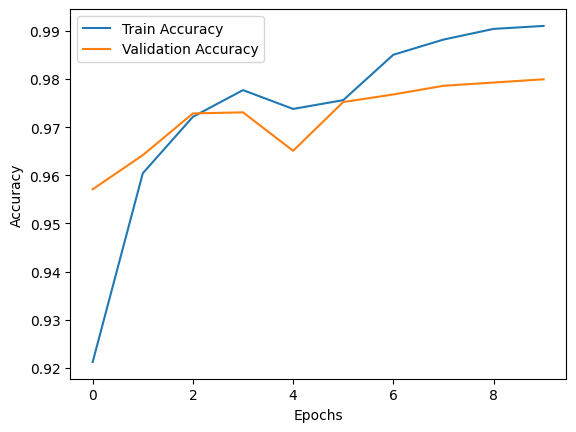

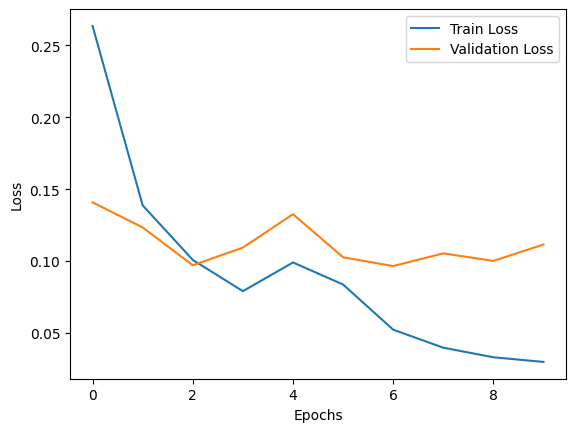

In [28]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


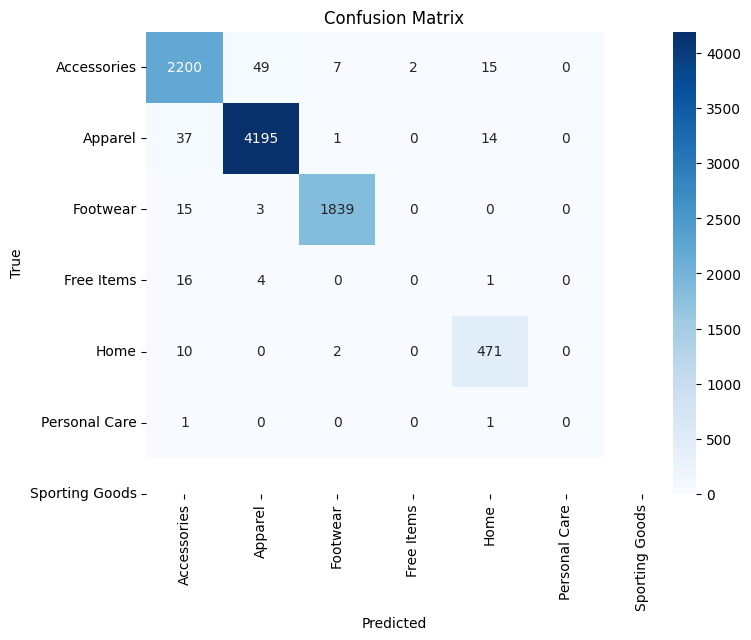

In [30]:
#confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=val_gen.class_indices.keys(),
            yticklabels=val_gen.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [32]:
#Predict on New Images


from tensorflow.keras.utils import load_img, img_to_array
import numpy as np

img_path = "/content/fashion_dataset/images/15970.jpg"  # change to any ID
img = load_img(img_path, target_size=(128,128))
img_array = img_to_array(img)/255.0
img_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)
pred_class = np.argmax(prediction)

class_labels = {v:k for k,v in val_gen.class_indices.items()}
print("Predicted class:", class_labels[pred_class])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
Predicted class: Apparel


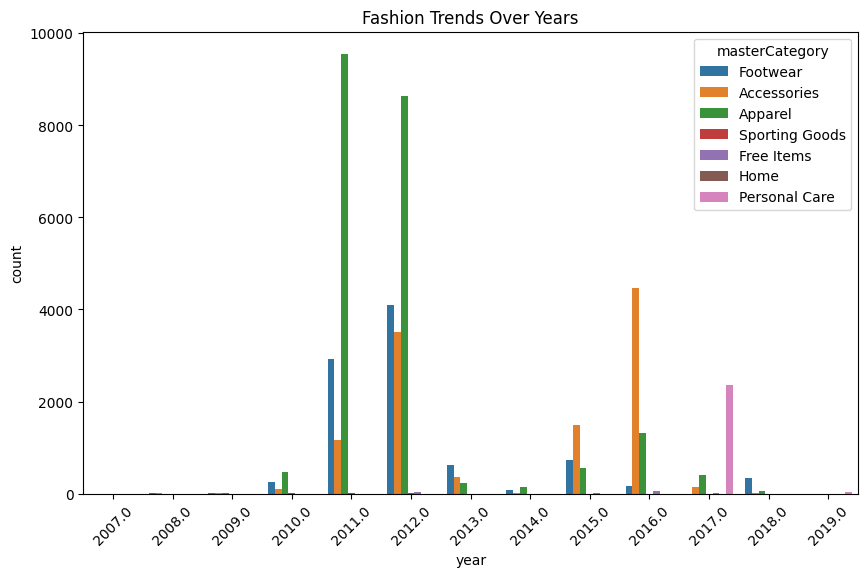

In [33]:
#Trend Analysis



import seaborn as sns

plt.figure(figsize=(10,6))
sns.countplot(x="year", hue="masterCategory", data=df)
plt.title("Fashion Trends Over Years")
plt.xticks(rotation=45)
plt.show()
